# Fine-tuning keras-ocr for seven segment OCR

In [ ]:
!pip install -qq -U git+https://github.com/faustomorales/keras-ocr.git#egg=keras-ocr
!pip install -qq imgaug
!pip install -qq -U opencv-python # We need the most recent version of OpenCV.

In [ ]:
!pip install tensorflow==2.11.0

In [ ]:
!pip install numpy==1.23.1

In [1]:
import random
import string
import math
import itertools
import os

import numpy as np
import imgaug as ia
import imgaug.augmenters as iaa
import matplotlib.pyplot as plt
import tensorflow as tf
import sklearn.model_selection

import keras_ocr

from matplotlib.pyplot import figure

%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

#### Create Data

In [ ]:

!unzip -qq new_ocr_dataset

In [2]:
data_dir = './new_ocr_dataset/new_ocr_dataset'
gt_file = f'{data_dir}/gt.txt'

with open(gt_file) as file:
    lines = file.read().splitlines()
    train_labels = [(data_dir + '/' + line.split('\t')[0], None, line.split('\t')[1]) for line in lines]

# train_labels = [(filepath, box, word.lower()) for filepath, box, word in train_labels]
# test_labels = [(filepath, box, word.lower()) for filepath, box, word in train_labels]

In [3]:
print(f'{train_labels} samples')

[('./new_ocr_dataset/new_ocr_dataset/LE_J02_35566915_2690297_694071400750347_1_20231011134142.JPG', None, '12993'), ('./new_ocr_dataset/new_ocr_dataset/LE_J02_35566915_2690297_694071400750348_1_20231011134247.JPG', None, '15246'), ('./new_ocr_dataset/new_ocr_dataset/LE_G45_34318111_1875892_694071500767019_1_20231011115544.JPG', None, '17543'), ('./new_ocr_dataset/new_ocr_dataset/LE_J09_301562396_1621038_690031301497409_1_20231012112822.JPG', None, '21570'), ('./new_ocr_dataset/new_ocr_dataset/LE_J09_301547148_1953507_640021314268776_1_20231010092045.JPG', None, '2133'), ('./new_ocr_dataset/new_ocr_dataset/LE_J02_301956350_1782436_640021314449024_1_20231010113519.JPG', None, '2801'), ('./new_ocr_dataset/new_ocr_dataset/LE_H02_20605960_30028802_640041350460389_1_20231027144833.JPG', None, '596378'), ('./new_ocr_dataset/new_ocr_dataset/LE_G45_20731465_30004445_640041350482194_1_20231027103154.JPG', None, '0'), ('./new_ocr_dataset/new_ocr_dataset/LE_G45_20731465_30004445_640041350482194_4_

We next build our recognizer, using the default options to get a pretrained model.

In [4]:
alphabet = string.digits
recognizer = keras_ocr.recognition.Recognizer(alphabet=alphabet,weights='kurapan')

# Compile the model (no changes here)
recognizer.compile()

print(recognizer.model.input_shape)

Provided alphabet does not match pretrained alphabet. Using backbone weights only.
Looking for C:\Users\Morvai Barna\.keras-ocr\crnn_kurapan_notop.h5
(None, 31, 200, 1)


In [5]:
detector = keras_ocr.detection.Detector(weights='clovaai_general')
recognizer = keras_ocr.recognition.Recognizer(
    alphabet=alphabet,
    weights='kurapan'
)
recognizer.compile()

Looking for C:\Users\Morvai Barna\.keras-ocr\craft_mlt_25k.h5
Provided alphabet does not match pretrained alphabet. Using backbone weights only.
Looking for C:\Users\Morvai Barna\.keras-ocr\crnn_kurapan_notop.h5


We will resize the images to 200x31 to match the models input

In [6]:
from PIL import Image
import os, sys

dirs = os.listdir(data_dir)
h, w = recognizer.model.input_shape[1], recognizer.model.input_shape[2]

def resize():
  for item in dirs:
    if os.path.isfile(data_dir+ '/' + item) and '.png' in item:
      im = Image.open(data_dir+ '/' + item)
      imResize = im.resize((w, h), Image.BICUBIC)
      imResize.save(data_dir + '/' + item, 'PNG')
  for item in dirs:
    if os.path.isfile(data_dir+ '/' + item) and '.JPG' in item:
      im = Image.open(data_dir+ '/' + item)
      imResize = im.resize((w, h), Image.BICUBIC)
      imResize.save(data_dir + '/' + item, 'PNG')

resize()

We need to convert our dataset into the format that :code:`keras-ocr` requires. To
do that, we have the following, which includes support for an augmenter to
generate synthetically altered samples. Note that this code is set up to skip
any characters that are not in the recognizer alphabet and that all labels
are first converted to lowercase.


In [7]:
# Sometimes(0.5, ...) applies the given augmenter in 50% of all cases,
# e.g. Sometimes(0.5, GaussianBlur(0.3)) would blur roughly every second
# image.
sometimes = lambda aug: iaa.Sometimes(0.5, aug)

augmenter = iaa.Sequential(
    [
        #
        # Apply the following augmenters to most images.
        #
        # iaa.Fliplr(0.5), # horizontally flip 50% of all images
        # iaa.Flipud(0.2), # vertically flip 20% of all images

        # crop some of the images by 0-10% of their height/width
        # sometimes(iaa.Crop(percent=(0, 0.1))),

        # Apply affine transformations to some of the images
        # - scale to 80-120% of image height/width (each axis independently)
        # - translate by -20 to +20 relative to height/width (per axis)
        # - rotate by -45 to +45 degrees
        # - shear by -16 to +16 degrees
        # - order: use nearest neighbour or bilinear interpolation (fast)
        # - mode: use any available mode to fill newly created pixels
        #         see API or scikit-image for which modes are available
        # - cval: if the mode is constant, then use a random brightness
        #         for the newly created pixels (e.g. sometimes black,
        #         sometimes white)
        # sometimes(iaa.Affine(
        #     scale={"x": (0.1, 1.1), "y": (0.1, 1.1)},
        #     #translate_percent={"x": (-0.05, 0.05), "y": (-0.05, 0.05)},
        #     rotate=(-10, 10),
        #     shear=(-8, 8),
        #     order=[0, 1],
        #     cval=(0, 255),
        #     mode='constant'
        # )),

        #
        # Execute 0 to 5 of the following (less important) augmenters per
        # image. Don't execute all of them, as that would often be way too
        # strong.
        #
        iaa.SomeOf((0, 3),
            [
                # Convert some images into their superpixel representation,
                # sample between 20 and 200 superpixels per image, but do
                # not replace all superpixels with their average, only
                # some of them (p_replace).
                # sometimes(
                #     iaa.Superpixels(
                #         p_replace=(0, 1.0),
                #         n_segments=(20, 200)
                #     )
                # ),

                # Blur each image with varying strength using
                # gaussian blur (sigma between 0 and 3.0),
                # average/uniform blur (kernel size between 2x2 and 7x7)
                # median blur (kernel size between 3x3 and 11x11).
                iaa.OneOf([
                    iaa.GaussianBlur((0, 1.0)),
                    iaa.AverageBlur(k=(1, 3)),
                    iaa.MedianBlur(k=(1, 3)),
                ]),

                # Sharpen each image, overlay the result with the original
                # image using an alpha between 0 (no sharpening) and 1
                # (full sharpening effect).
                iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5)),

                # Same as sharpen, but for an embossing effect.
                iaa.Emboss(alpha=(0, 1.0), strength=(0, 2.0)),

                # Search in some images either for all edges or for
                # directed edges. These edges are then marked in a black
                # and white image and overlayed with the original image
                # using an alpha of 0 to 0.7.
                sometimes(iaa.OneOf([
                    iaa.EdgeDetect(alpha=(0, 0.25)),
                    iaa.DirectedEdgeDetect(
                        alpha=(0, 0.5), direction=(0.0, 0.2)
                    ),
                ])),

                # Add gaussian noise to some images.
                # In 50% of these cases, the noise is randomly sampled per
                # channel and pixel.
                # In the other 50% of all cases it is sampled once per
                # pixel (i.e. brightness change).
                # iaa.AdditiveGaussianNoise(
                #     loc=0, scale=(0.0, 0.03*255), per_channel=0.5
                # ),

                # Either drop randomly 1 to 10% of all pixels (i.e. set
                # them to black) or drop them on an image with 2-5% percent
                # of the original size, leading to large dropped
                # rectangles.
                # iaa.OneOf([
                #     iaa.Dropout((0.01, 0.1), per_channel=0.5),
                #     iaa.CoarseDropout(
                #         (0.03, 0.15), size_percent=(0.02, 0.05),
                #         per_channel=0.2
                #     ),
                # ]),

                # Invert each image's channel with 5% probability.
                # This sets each pixel value v to 255-v.
                iaa.Invert(0.05, per_channel=True), # invert color channels

                # Add a value of -10 to 10 to each pixel.
                iaa.Add((-10, 10), per_channel=0.5),

                # Change brightness of images (50-150% of original value).
                # iaa.Multiply((0.7, 1.2), per_channel=0.5),

                # Improve or worsen the contrast of images.
                iaa.LinearContrast((0.5, 2.0), per_channel=0.5),

                # Convert each image to grayscale and then overlay the
                # result with the original with random alpha. I.e. remove
                # colors with varying strengths.
                iaa.Grayscale(alpha=(0.0, 1.0)),

                # In some images move pixels locally around (with random
                # strengths).
                # sometimes(
                #     iaa.ElasticTransformation(alpha=(0.5, 3.5), sigma=0.25)
                # ),

                # In some images distort local areas with varying strength.
                # sometimes(iaa.PiecewiseAffine(scale=(0.01, 0.05))),

                # sometimes(iaa.JpegCompression(compression=(70, 99)))
            ],
            # do all of the above augmentations in random order
            random_order=True
        )
    ],
    # do all of the above augmentations in random order
    random_order=True
)

print()

As a sanity check, we show one of the samples.

In [8]:
batch_size = 8

train_labels, validation_labels = sklearn.model_selection.train_test_split(train_labels, test_size=0.2, random_state=42)
(training_image_gen, training_steps), (validation_image_gen, validation_steps) = [
    (
        keras_ocr.datasets.get_recognizer_image_generator(
            labels=labels,
            height=recognizer.model.input_shape[1],
            width=recognizer.model.input_shape[2],
            alphabet=recognizer.alphabet,
            augmenter=augmenter
        ),
        len(labels) // batch_size
    ) for labels, augmenter in [(train_labels, augmenter), (validation_labels, None)]
]
training_gen, validation_gen = [
    recognizer.get_batch_generator(
        image_generator=image_generator,
        batch_size=batch_size
    )
    for image_generator in [training_image_gen, validation_image_gen]
]

text: 16641
(31, 200, 3)


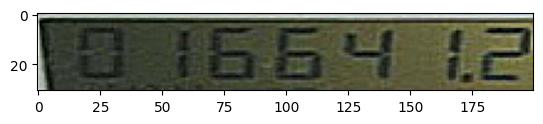

In [10]:
image, text = next(training_image_gen)
print('text:', text)
_ = plt.imshow(image)
print(image.shape)


Now we can run training.

Epoch 1/300
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
35/35 [==============================] - 63s 2s/step - loss: 12.9799 - val_loss: 10.2647
Epoch 2/300
35/35 [==============================] - 54s 2s/step - loss: 8.8931 - val_loss: 5.5122
Epoch 3/300
35/35 [==============================] - 54s 2s/step - loss: 3.3450 - val_loss: 2.1734
Epoch 4/300
35/35 [==============================] - 54s 2s/step - loss: 1.7296 - val_loss: 8.3554
Epoch 5/300
35/35 [==============================] - 54s 2s/step - loss: 1.5465 - val_loss: 1.6822
Epoch 6/300
35/35 [==============================] - 54s 2s/step - loss: 1.3627 - val_loss: 1.6726
Epoch 7/300
35/35 [==============================] - 54s 2s/step - loss: 1.2447 - val_loss: 1.8905
Epoch 8/300
35/35 [==============================] - 54s 2s/step - loss: 0.7177 - val_loss: 1.0929
Epoch

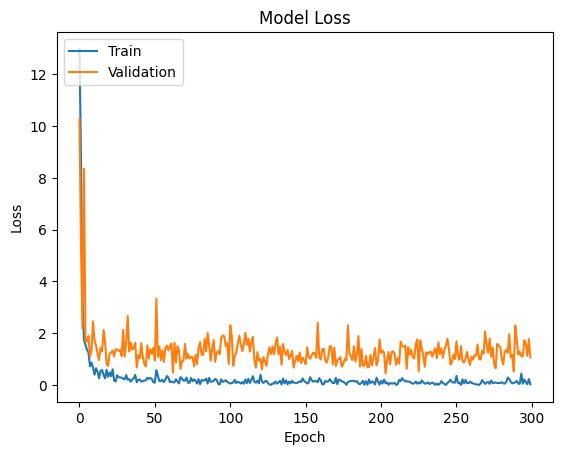

In [11]:
callbacks = [
    # tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, restore_best_weights=False),
    tf.keras.callbacks.ModelCheckpoint('meeter_rec.h5', monitor='loss', save_best_only=True),
    tf.keras.callbacks.CSVLogger('meeter_rec.csv')
]

history = recognizer.training_model.fit(
    x=training_gen,
    steps_per_epoch=training_steps,
    validation_steps=validation_steps,
    validation_data=validation_gen,
    callbacks=callbacks,
    epochs=300,
    verbose=1
)

# Plot training & validation accuracy values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Finally, run inference on a test sample.

In [ ]:
# recognizer.prediction_model.save("model")

1/1 [==============================] - 0s 72ms/step
Predicted: 2386, Actual: 2386


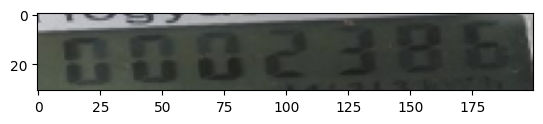

In [16]:
import random as rnd
image_filepath, _, actual = validation_labels[rnd.randint(0, len(validation_labels))]
predicted = recognizer.recognize(image_filepath)
print(f'Predicted: {predicted}, Actual: {actual}')
_ = plt.imshow(keras_ocr.tools.read(image_filepath))

### Evaluation

1/1 [==============================] - 0s 60ms/step
Validaton Accuracy: 0.7777777777777778


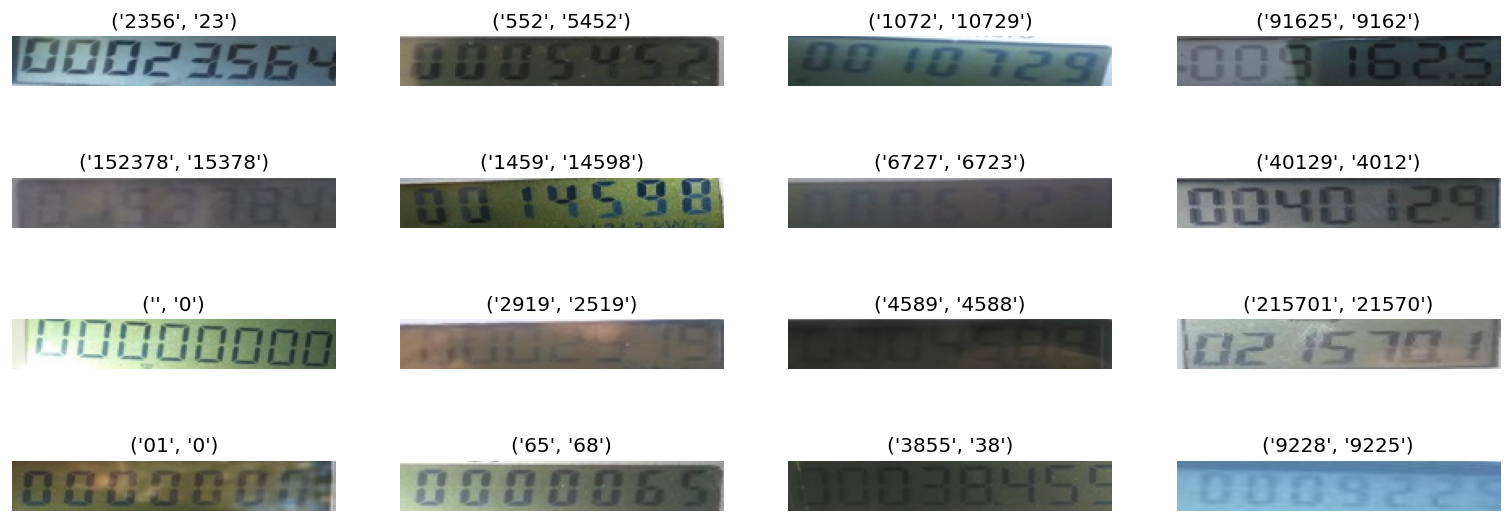

In [17]:
figure(figsize=(16, 12), dpi=120)
results, labels, predictions = [], [], []
i = 0

for image_filepath, _, actual in validation_labels:
  actual = actual
  predicted = recognizer.recognize(image_filepath)
  results.append(predicted == actual)

  if len(actual) == len(predicted):
    labels.extend(list(actual))
    predictions.extend(list(predicted))

  if predicted != actual:
    img = Image.open(image_filepath)
    plt.subplot(8,4, i+1)
    plt.title((predicted,actual))
    plt.axis('off')
    plt.imshow(img)
    i+=1

print(f'Validaton Accuracy: {sum(results)/len(results)}')

In [18]:
#@title

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(12, 8), dpi=80)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = 100*cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.0f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

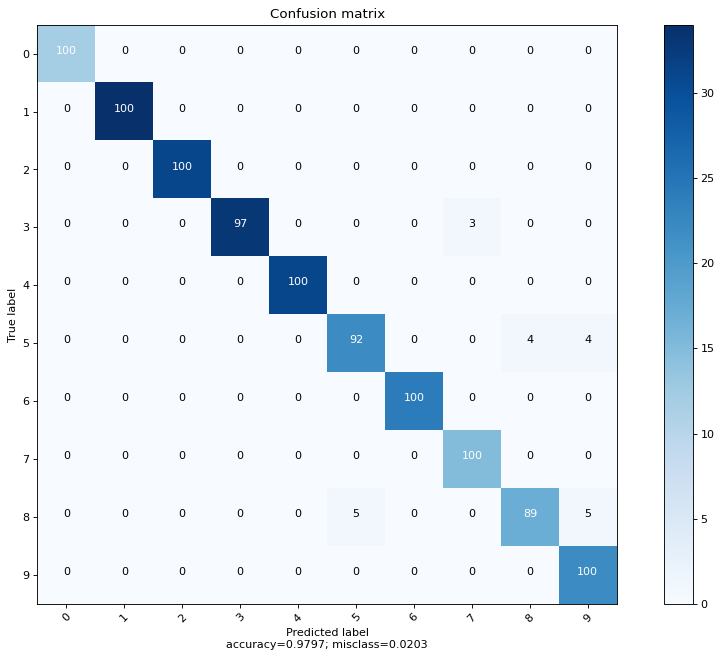

In [19]:
from sklearn.metrics import confusion_matrix

target_labels=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
cf_matrix = confusion_matrix(labels, predictions, labels=target_labels)

plot_confusion_matrix(cm=cf_matrix,
                      target_names=target_labels,
                      normalize=True)

#### TFLite convertion

In [20]:
def convert_tflite(quantization, prediction_model):
  converter = tf.lite.TFLiteConverter.from_keras_model(prediction_model)
  converter.optimizations = [tf.lite.Optimize.DEFAULT]
  converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS, # enable TensorFlow Lite ops.
    tf.lite.OpsSet.SELECT_TF_OPS # enable TensorFlow ops.
  ]
  if quantization == 'float16':
    converter.target_spec.supported_types = [tf.float16]
  # elif quantization == 'int8' or quantization == 'full_int8':
  #   converter.representative_dataset = representative_data_gen
  if quantization == 'full_int8':
    converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
    converter.inference_input_type = tf.int8  # or tf.uint8
    converter.inference_output_type = tf.int8  # or tf.uint8
  tf_lite_model = converter.convert()
  open(f'meeter_rec_{quantization}.tflite', 'wb').write(tf_lite_model)

In [21]:
for quantization in ['float16']:
  convert_tflite(quantization, recognizer.prediction_model)

INFO:tensorflow:Assets written to: C:\Users\MORVAI~1\AppData\Local\Temp\tmpecy2l_sh\assets


INFO:tensorflow:Assets written to: C:\Users\MORVAI~1\AppData\Local\Temp\tmpecy2l_sh\assets
